In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def binary_dataframes(root_dir, category):
  '''
  Will return data specific to one of the category

  category = 'commenting' or 'groping' or 'ogling'
  '''

  dir = root_dir+'binary_classification/'
  train = pd.read_csv(dir+category+'_data/train.csv')
  cv = pd.read_csv(dir+category+'_data/dev.csv')
  test = pd.read_csv(dir+category+'_data/test.csv') 

  return pd.concat([train, cv], axis=0, ignore_index=True) , test

def multilabel_dataframe(root_dir):
  '''
  Will return multiple labeled data 
  '''
  dir = root_dir+'multilabel_classification/'
  train = pd.read_csv(dir+'train.csv')
  cv = pd.read_csv(dir+'dev.csv')
  test = pd.read_csv(dir+'test.csv') 

  return pd.concat([train, cv], axis=0, ignore_index=True), test

def stemming(sent):
  snow_stemmer = SnowballStemmer(language='english')

  stem_words = []
  for word in sent.split(" "):
    x = snow_stemmer.stem(word)
    stem_words.append(x)

  return " ".join(stem_words)

def stop_word(sent):
  en_stops = set(stopwords.words('english'))

  filter = []
  for word in sent.split(" "): 
    if word.lower() not in en_stops or word.lower() == 'not':
        filter.append(word)
  
  return " ".join(filter)

def fetch_data(root_dir, label_type, stem, rm_stopword, vectorizer, min_df, max_df, category=None):
  '''
  root_dir : <string> path of directory where data is stored

  label_type: <string> 'binary' or 'multi'

  stem: <bool> True or False

  rm_stopword: <bool> True or False

  vectorizer: <string> "bow" or "tfidf"

  min_freq: <int> word to consider having minimum frequency

  mix_freq: <int> word not to consider more than this frequency 

  category : <string> 'commenting' or 'ogling' or 'groping'
  '''

  if label_type == 'binary':
    train, test = binary_dataframes(root_dir, category)
    
    if stem:
      train['Description'] = train['Description'].map(stemming)
      test['Description'] = test['Description'].map(stemming)
    if rm_stopword:
      train['Description'] = train['Description'].map(stop_word)
      test['Description'] = test['Description'].map(stop_word)

  elif label_type == 'multi':
    train, test = binary_dataframes(root_dir, category)
    
    if stem:
      train['Description'] = train['Description'].map(stemming)
      test['Description'] = test['Description'].map(stemming)
    
    if rm_stopword:
      train['Description'] = train['Description'].map(stop_word)
      test['Description'] = test['Description'].map(stop_word)

    else:
      return "wrong label type."

  if vectorizer == "bow":
    vec = CountVectorizer(min_df=min_df, max_df=max_df)
    vec.fit(train['Description'])
    
    trans = vec.transform(train['Description'])
    train = pd.concat([pd.DataFrame(trans.toarray(), columns=vec.vocabulary_), train.drop(['Description'], axis=1)], axis=1)
    
    trans = vec.transform(test['Description'])
    test = pd.concat([pd.DataFrame(trans.toarray(), columns=vec.vocabulary_), test.drop(['Description'], axis=1)], axis=1)
  
  if vectorizer == "tfidf":
    vec = TfidfVectorizer(min_df=min_df, max_df=max_df)
    vec.fit(train['Description'])
    
    trans = vec.transform(train['Description'])
    train = pd.concat([pd.DataFrame(trans.toarray(), columns=vec.vocabulary_), train.drop(['Description'], axis=1)], axis=1)

    trans = vec.transform(test['Description'])
    test = pd.concat([pd.DataFrame(trans.toarray(), columns=vec.vocabulary_), test.drop(['Description'], axis=1)], axis=1)
  
  return train, test, vec

In [ ]:
root_dir = "safecity-master/"

# Modelling commenting

In [ ]:
model = {
    "model": [],
    "stemming": [],
    "vectorizer": [],
    "train_accuracy": [],
    "test_accuracy": []
}

In [ ]:
# stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=True, rm_stopword=True, 
                             vectorizer="bow", min_df=1, max_df=1404, category="commenting")

Y_train_stem, X_train_stem = train['Category'], train.drop(['Category'], axis=1)
Y_test_stem, X_test_stem = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walk,along,crowd,street,hold,mum,hand,elder,man,grope,butt,turn,look,h7m,away,while,12,yrs,old,then,incid,took,place,evening,metro,two,guy,start,staring,wait,bus,came,bike,offer,liftvto,young,girls,happen,insid,train,...,uma,begumpet,kundanbagh,kilomet,cries,ba,9861,ameerpet,youngsters,leelanagar,imax,perverts,lout,muscular,boda,oper,ferri,thye,curvi,sweets,underag,relis,gr,senset,onlook,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutub,downloaderlt,agt,folow,offending,cgrope,timr,Category
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# not stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=False, rm_stopword=True, 
                             vectorizer="bow", min_df=1, max_df=1404, category="commenting")

Y_train_not_stem, X_train_not_stem = train['Category'], train.drop(['Category'], axis=1)
Y_test_not_stem, X_test_not_stem = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walking,along,crowded,street,holding,mums,hand,elderly,man,groped,butt,turned,look,h7m,looked,away,while,12,yrs,old,then,incident,took,place,evening,metro,two,guys,started,staring,waiting,bus,came,bike,offering,liftvto,young,girls,happened,inside,...,ameerpet,leelanagar,echoes,imax,crack,powerful,muscular,photocopying,boda,operators,ferry,thye,shapes,curvy,identifying,policing,oftenly,underage,relise,mention,gr,sensetive,impregnates,onlookers,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutube,downloaderlt,agt,folowing,cgroping,timr,conducter,gift,Category
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=True, rm_stopword=True, 
                             vectorizer="tfidf", min_df=1, max_df=1404, category="commenting")

Y_train_stem_, X_train_stem_ = train['Category'], train.drop(['Category'], axis=1)
Y_test_stem_, X_test_stem_ = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walk,along,crowd,street,hold,mum,hand,elder,man,grope,butt,turn,look,h7m,away,while,12,yrs,old,then,incid,took,place,evening,metro,two,guy,start,staring,wait,bus,came,bike,offer,liftvto,young,girls,happen,insid,train,...,uma,begumpet,kundanbagh,kilomet,cries,ba,9861,ameerpet,youngsters,leelanagar,imax,perverts,lout,muscular,boda,oper,ferri,thye,curvi,sweets,underag,relis,gr,senset,onlook,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutub,downloaderlt,agt,folow,offending,cgrope,timr,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=False, rm_stopword=True, 
                             vectorizer="tfidf", min_df=1, max_df=1404, category="commenting")

Y_train_not_stem_, X_train_not_stem_ = train['Category'], train.drop(['Category'], axis=1)
Y_test_not_stem_, X_test_not_stem_ = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walking,along,crowded,street,holding,mums,hand,elderly,man,groped,butt,turned,look,h7m,looked,away,while,12,yrs,old,then,incident,took,place,evening,metro,two,guys,started,staring,waiting,bus,came,bike,offering,liftvto,young,girls,happened,inside,...,ameerpet,leelanagar,echoes,imax,crack,powerful,muscular,photocopying,boda,operators,ferry,thye,shapes,curvy,identifying,policing,oftenly,underage,relise,mention,gr,sensetive,impregnates,onlookers,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutube,downloaderlt,agt,folowing,cgroping,timr,conducter,gift,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Logistic regression with BOW and stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem, Y_train_stem)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   32.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

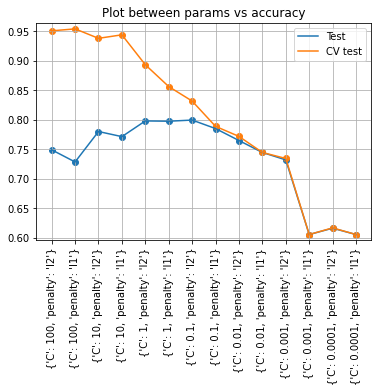

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')
plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=0.1)
clf.fit(X_train_stem, Y_train_stem)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("Yes")
model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_stem, clf.predict(X_test_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_stem, clf.predict(X_train_stem)))

print("Train accuracy : ", accuracy_score(Y_train_stem, clf.predict(X_train_stem)))
print("Test accuracy : ", accuracy_score(Y_test_stem, clf.predict(X_test_stem)))

Train accuracy :  0.7920888780368698
Test accuracy :  0.798941798941799


## Logistic regression with BOW and not stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem, Y_train_not_stem)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   34.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

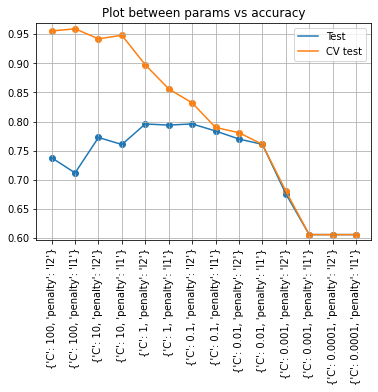

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=0.1)
clf.fit(X_train_not_stem, Y_train_not_stem)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("No")
model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))

Train accuracy :  0.7926993041142718
Test accuracy :  0.8018812463256908


## Light GBM with BOW and stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem, Y_train_stem)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 18.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

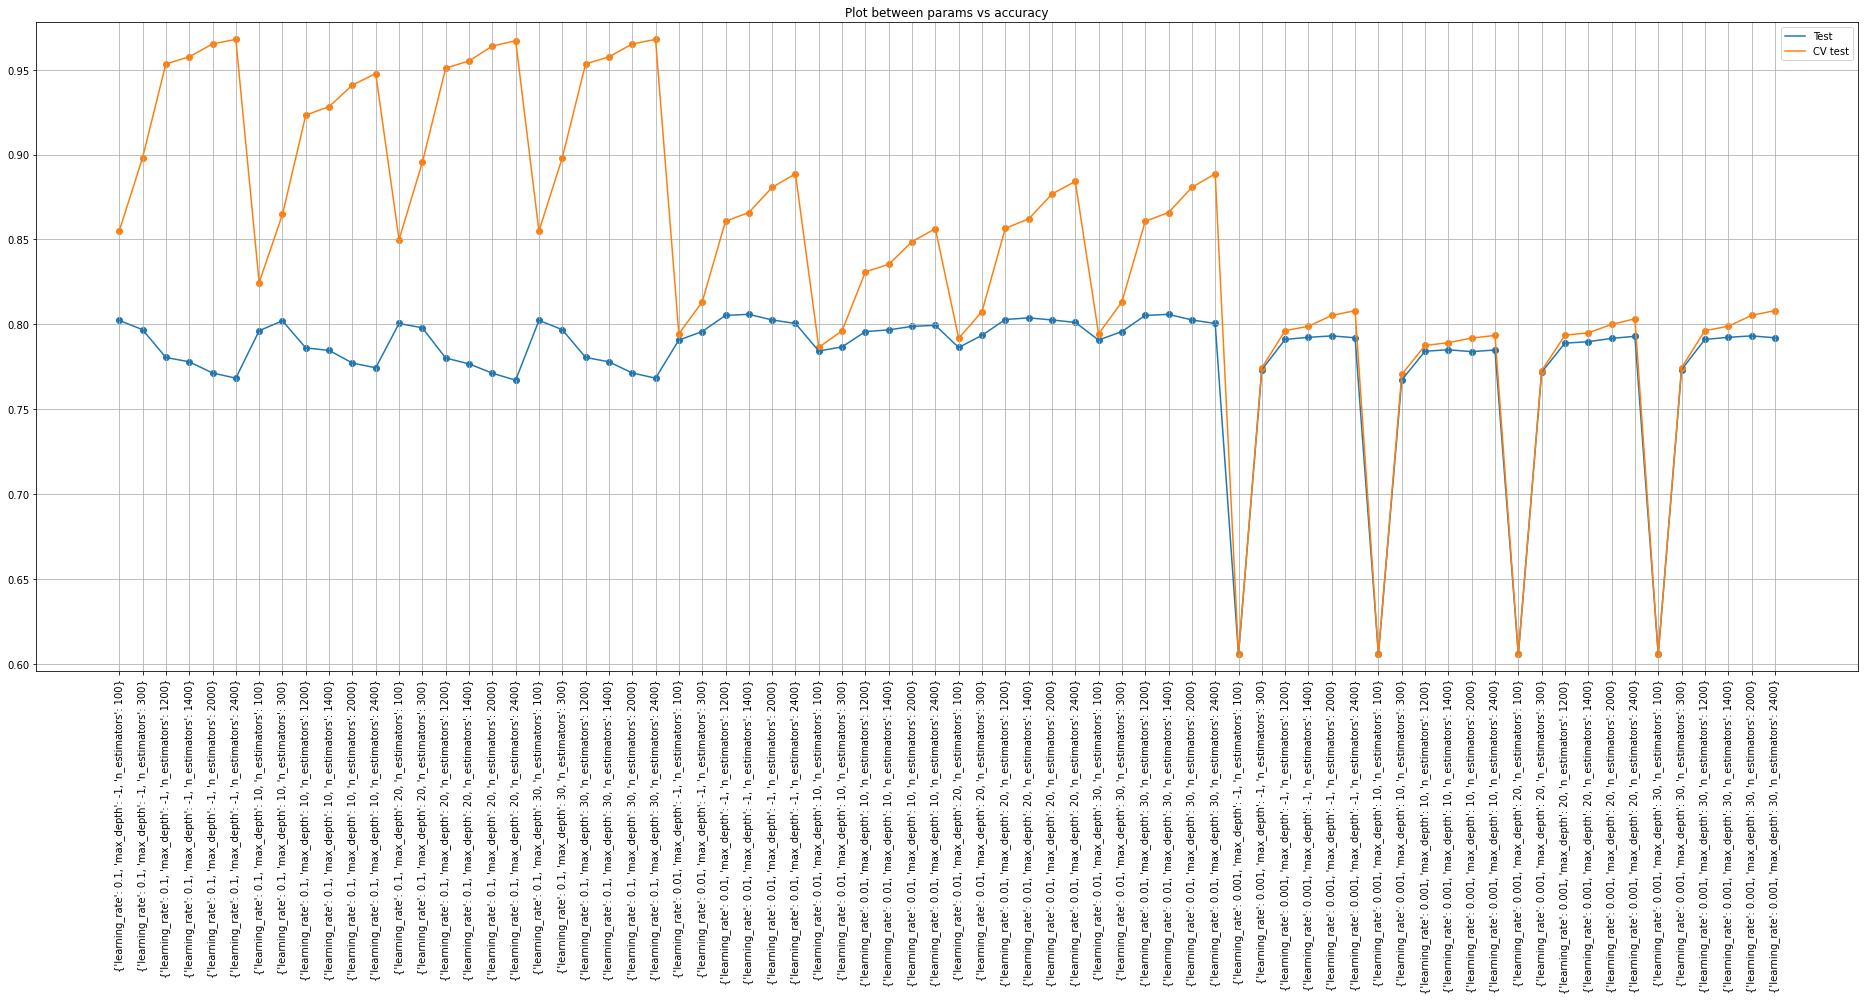

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=100, max_depth=-1, learning_rate=0.01)
clf.fit(X_train_stem, Y_train_stem)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("Yes")

model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_stem, clf.predict(X_test_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_stem, clf.predict(X_train_stem)))

print("Train accuracy : ", accuracy_score(Y_train_stem, clf.predict(X_train_stem)))
print("Test accuracy : ", accuracy_score(Y_test_stem, clf.predict(X_test_stem)))

Train accuracy :  0.7956293492858015
Test accuracy :  0.8024691358024691


## Light GBM with BOW and without stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem, Y_train_not_stem)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 20.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

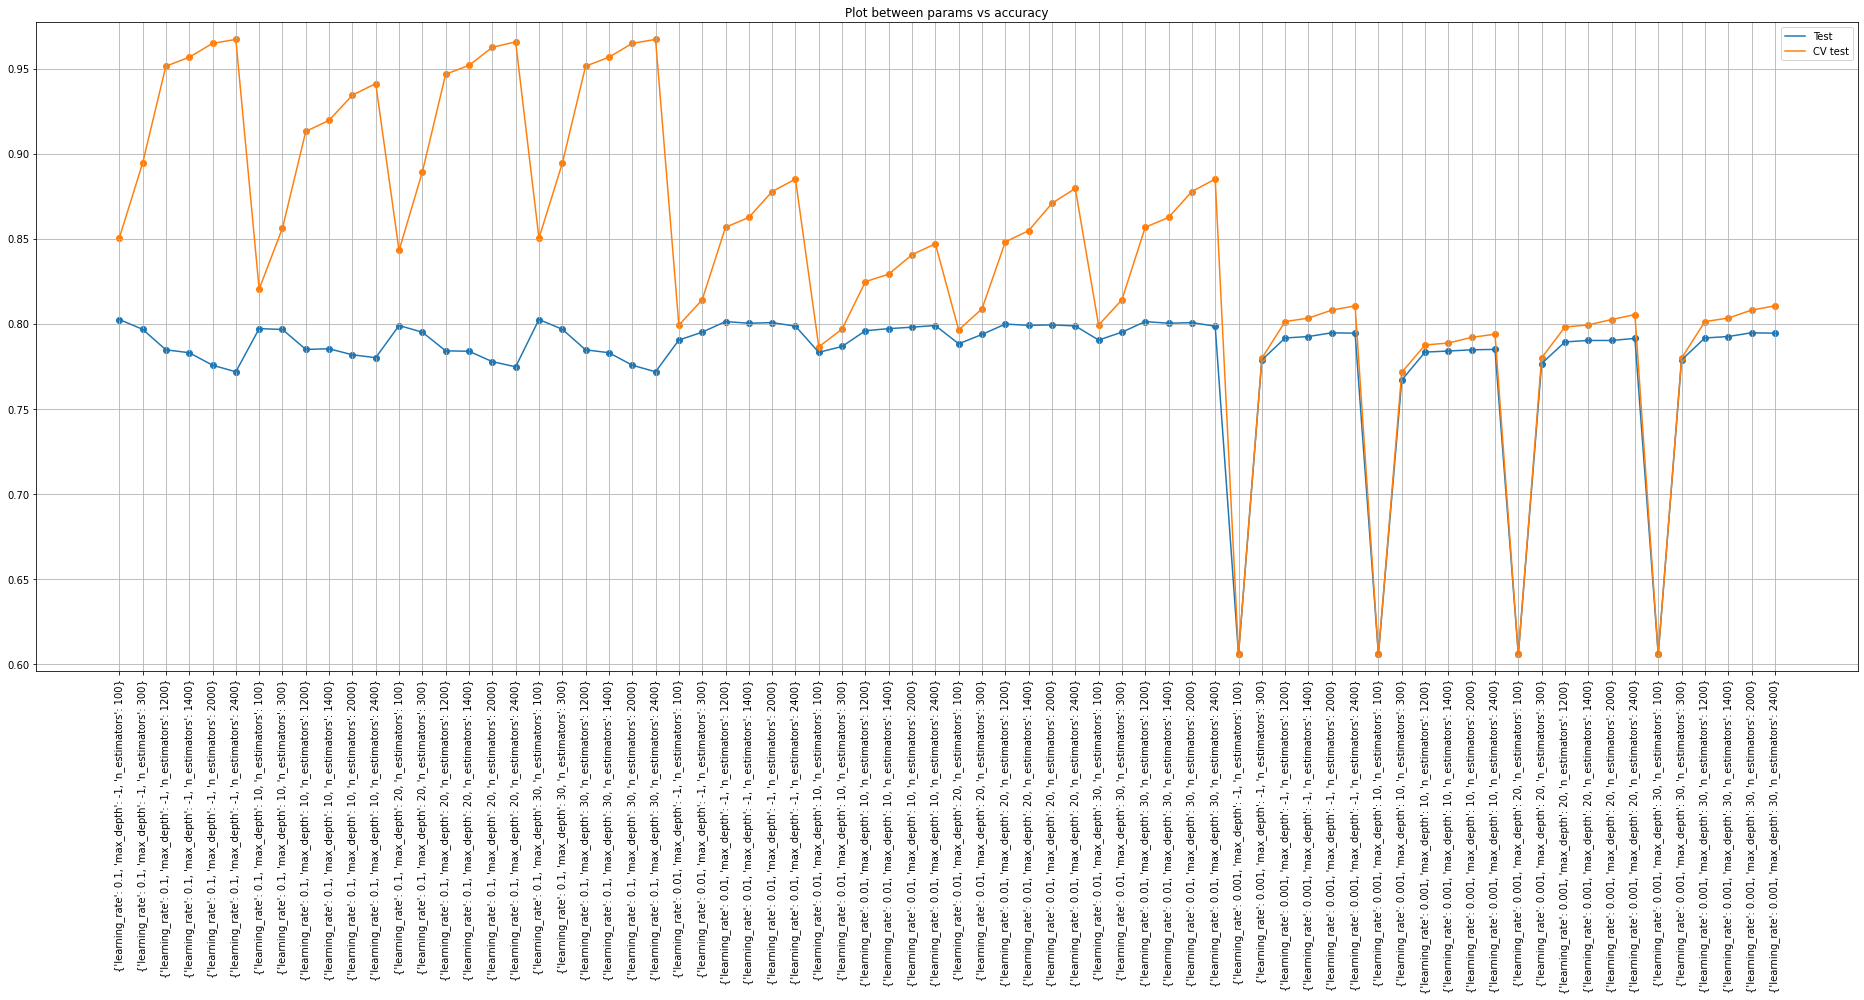

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=100, max_depth=-1, learning_rate=0.01)
clf.fit(X_train_not_stem, Y_train_not_stem)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("No")

model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))

Train accuracy :  0.7996581613966549
Test accuracy :  0.8083480305702528


## Logistic regression with TFIDF and stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem_, Y_train_stem_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   19.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

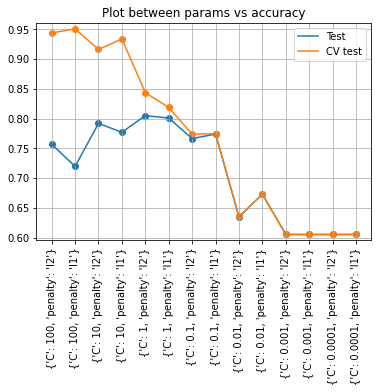

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')
plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=0.1)
clf.fit(X_train_stem_, Y_train_stem_)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("Yes")
model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_stem_, clf.predict(X_test_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_stem_, clf.predict(X_train_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_stem, clf.predict(X_train_stem)))
print("Test accuracy : ", accuracy_score(Y_test_stem, clf.predict(X_test_stem)))

Train accuracy :  0.7701135392503968
Test accuracy :  0.7619047619047619


## Logistic regression with TFIDF and not stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem_, Y_train_not_stem_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   20.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

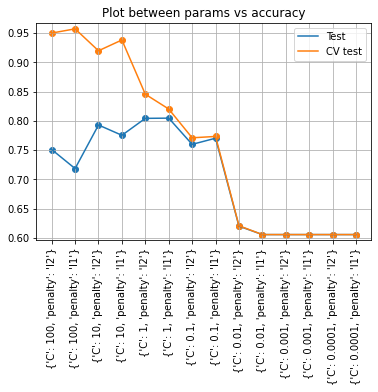

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=1)
clf.fit(X_train_not_stem_, Y_train_not_stem_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("No")
model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))

Train accuracy :  0.8238310340617752
Test accuracy :  0.8154027042915932


## Light GBM with TFIDF and stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem_, Y_train_stem_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 35.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

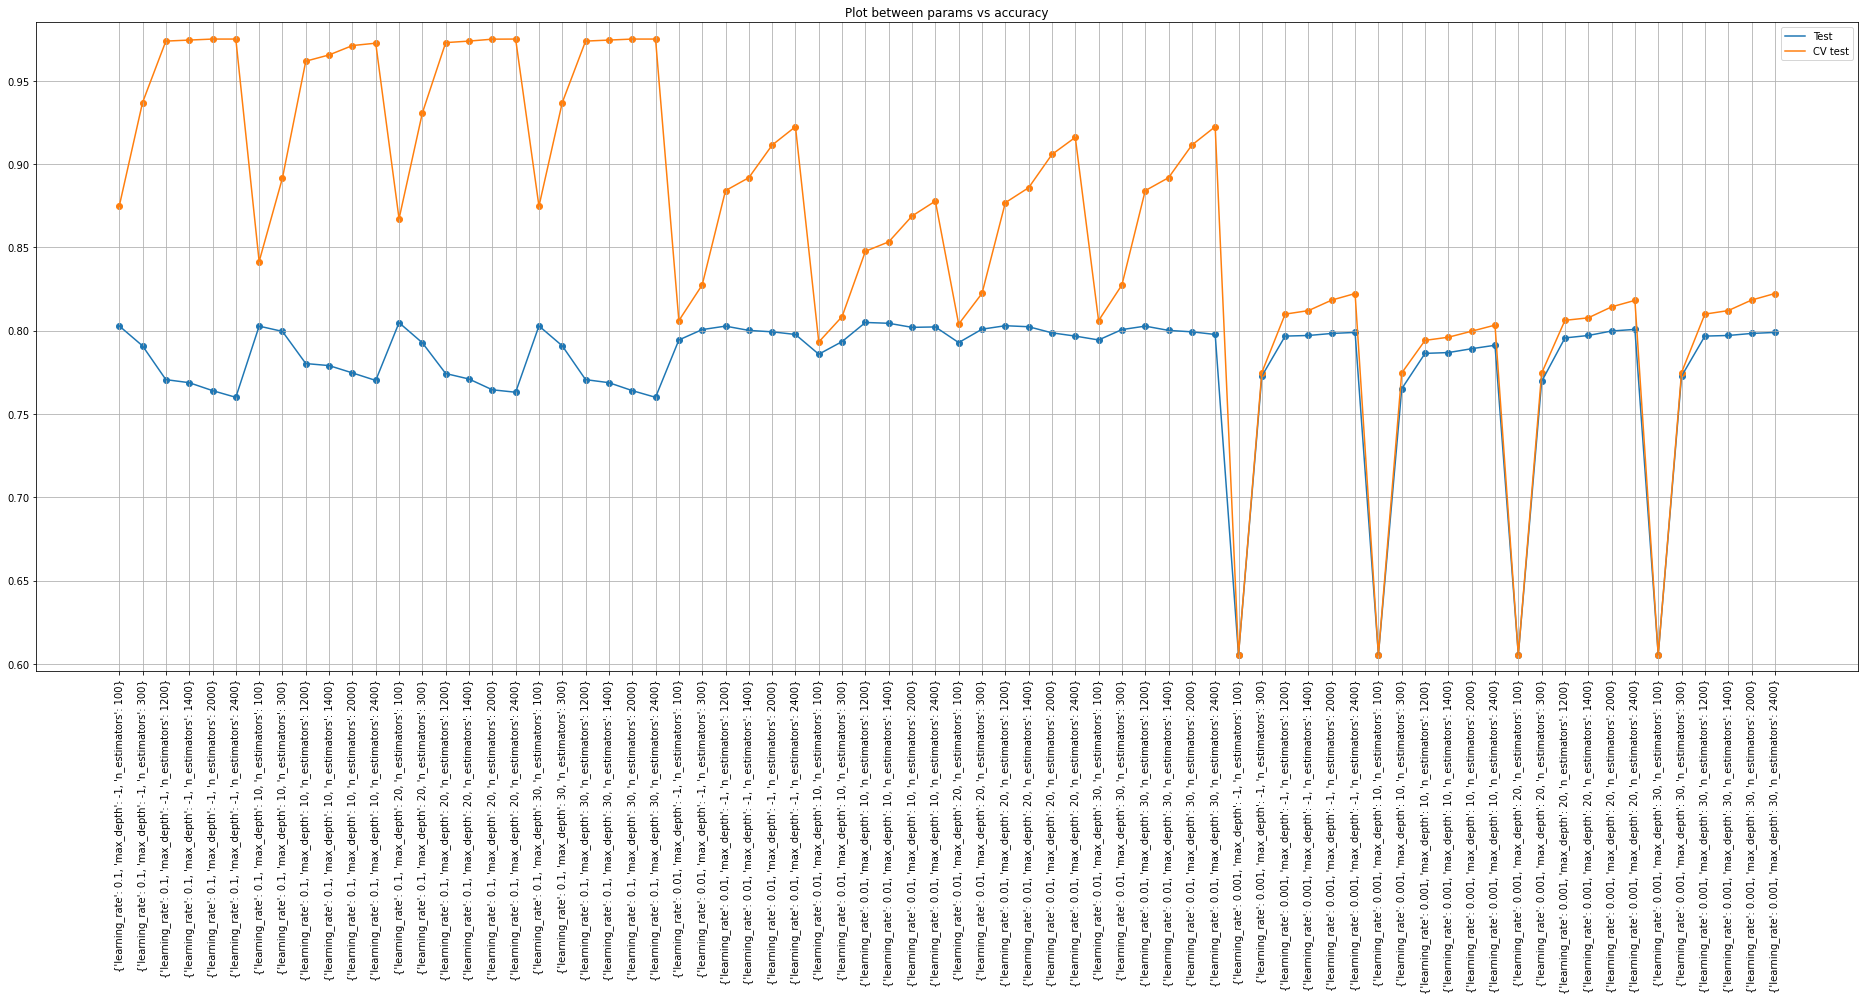

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=100, max_depth=-1, learning_rate=0.01)
clf.fit(X_train_stem_, Y_train_stem_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("Yes")

model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_stem_, clf.predict(X_test_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_stem_, clf.predict(X_train_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_stem_, clf.predict(X_train_stem_)))
print("Test accuracy : ", accuracy_score(Y_test_stem_, clf.predict(X_test_stem_)))

Train accuracy :  0.8046636552313515
Test accuracy :  0.8059964726631393


## Light GBM with TFIDF and without stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem_, Y_train_not_stem_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 38.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

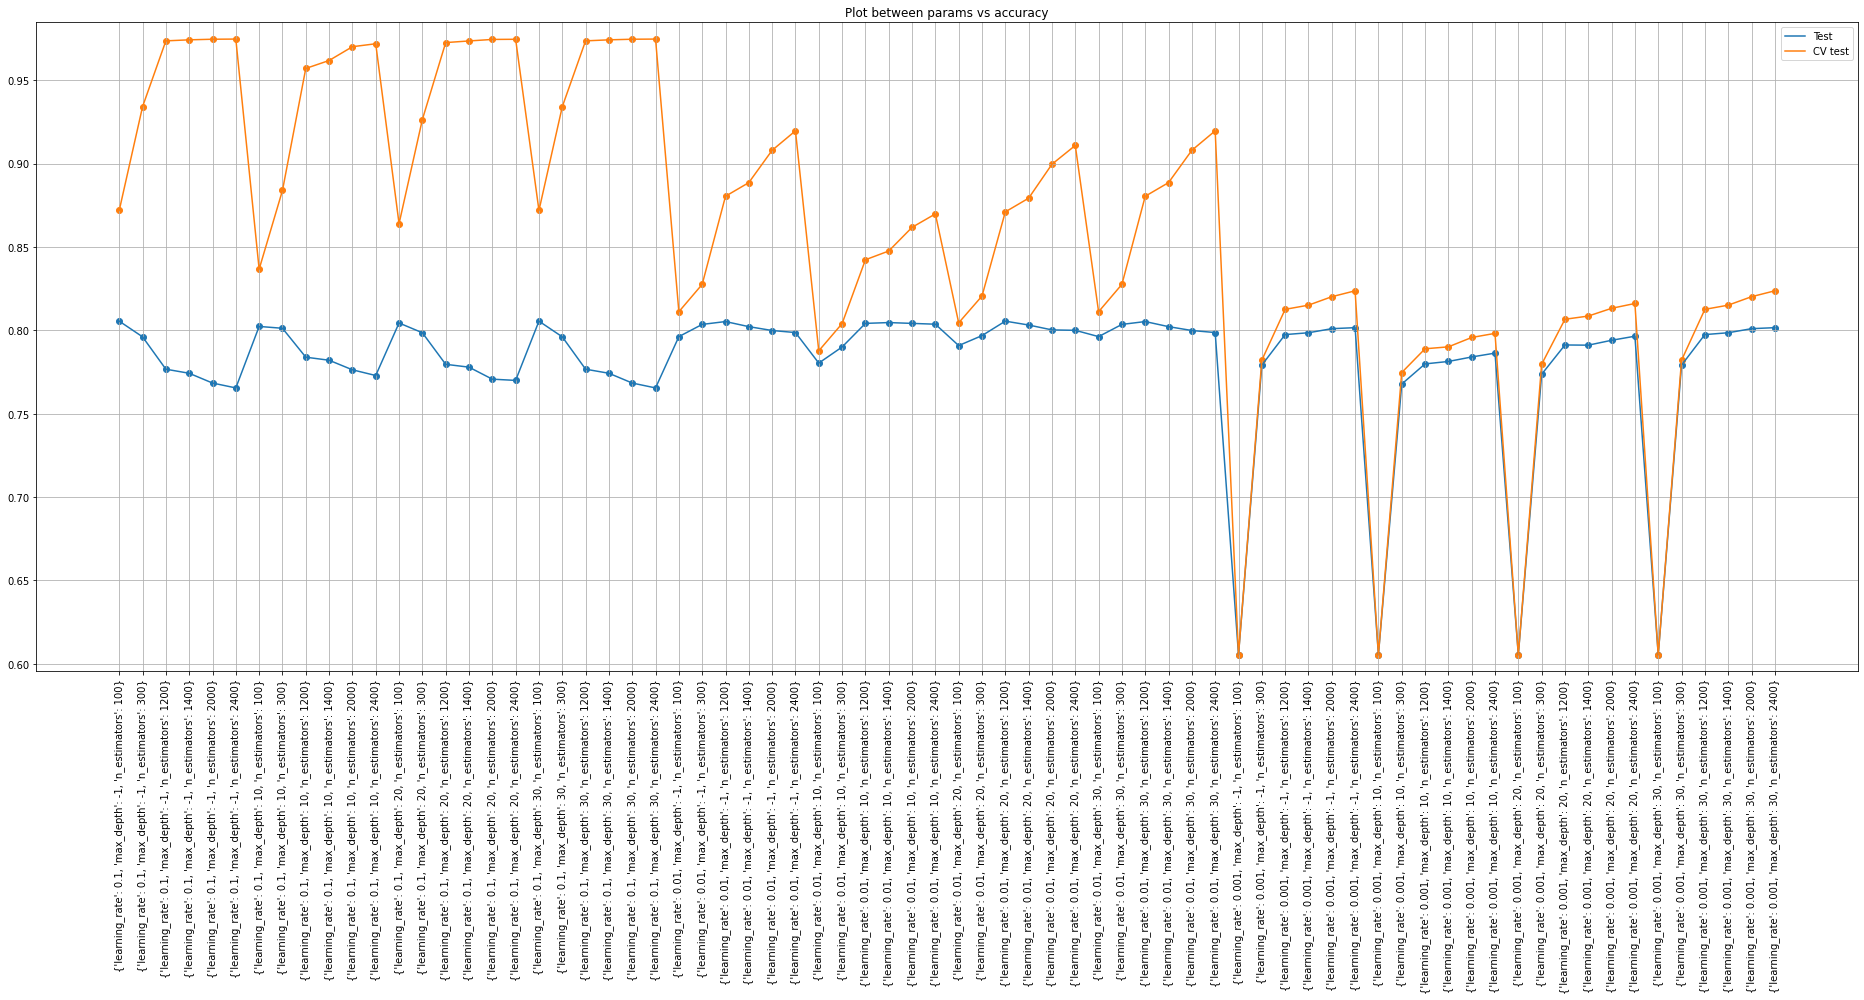

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=100, max_depth=-1, learning_rate=0.01)
clf.fit(X_train_not_stem_, Y_train_not_stem_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("No")

model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))

Train accuracy :  0.8112562568672934
Test accuracy :  0.8142269253380364


## Modeling Analysis

In [ ]:
model_df = pd.DataFrame(model)
model_df

,model,stemming,vectorizer,train_accuracy,test_accuracy
0,Logistic Rgression,Yes,BOW,0.792089,0.798942
1,Logistic Rgression,No,BOW,0.792699,0.801881
2,Light GBM,Yes,BOW,0.795629,0.802469
3,Light GBM,No,BOW,0.799658,0.808348
4,Logistic Rgression,Yes,TFIDF,0.780369,0.790711
5,Logistic Rgression,No,TFIDF,0.823831,0.815403
6,Light GBM,Yes,TFIDF,0.804664,0.805996
7,Light GBM,No,TFIDF,0.811256,0.814227


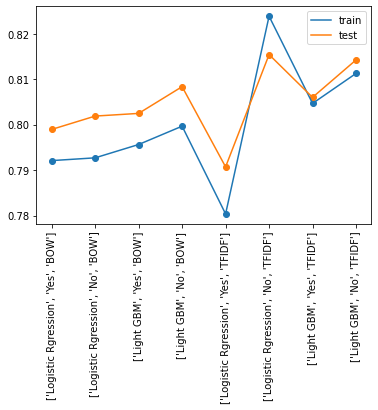

In [ ]:
plt.plot(model_df['train_accuracy'], label="train")
plt.plot(model_df['test_accuracy'], label="test")

plt.scatter(np.arange(0, model_df.shape[0]),model_df['train_accuracy'])
plt.scatter(np.arange(0, model_df.shape[0]),model_df['test_accuracy'])

plt.xticks(np.arange(0, model_df.shape[0]), [[i, j, k] for i, j, k in zip(model_df['model'], model_df['stemming'], model_df['vectorizer'])], rotation='vertical')

plt.legend()
plt.show()

<h1>Observation</h1>

We can see that we have choosen two different modelling technique one is logistic regression and another is lightGBM. 

For each of these modelling technique we are fitting it by changing vectorizers and with stemming option.

<h1>Conclusion</h1>
The highest accuracy we have achieved is 81.54 using logistic regression and 81.42 using lightgbm. Tfidf vectorizer is common in both without stemming. In paper they have used 7 modelling techniques 4 from ML and 3 from DL. We are able to beat the scores of 6 modelling techniques as of now for commenting and only 0.1 behind from best modelling technique. 

LightGBM is not overfitting 

Logistic regression is slightly overfitting.

For now TFIDF is best vectorization technique without stemming and for now lets take both LightGBM and Logistic regression. 

# Modelling groping

In [ ]:
model = {
    "model": [],
    "stemming": [],
    "vectorizer": [],
    "train_accuracy": [],
    "test_accuracy": []
}

In [ ]:
# stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=True, rm_stopword=True, 
                             vectorizer="bow", min_df=1, max_df=1404, category="groping")

Y_train_stem, X_train_stem = train['Category'], train.drop(['Category'], axis=1)
Y_test_stem, X_test_stem = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walk,along,crowd,street,hold,mum,hand,elder,man,grope,butt,turn,look,h7m,away,while,12,yrs,old,then,incid,took,place,evening,metro,two,guy,start,staring,wait,bus,came,bike,offer,liftvto,young,girls,happen,insid,train,...,uma,begumpet,kundanbagh,kilomet,cries,ba,9861,ameerpet,youngsters,leelanagar,imax,perverts,lout,muscular,boda,oper,ferri,thye,curvi,sweets,underag,relis,gr,senset,onlook,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutub,downloaderlt,agt,folow,offending,cgrope,timr,Category
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# not stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=False, rm_stopword=True, 
                             vectorizer="bow", min_df=1, max_df=1404, category="groping")

Y_train_not_stem, X_train_not_stem = train['Category'], train.drop(['Category'], axis=1)
Y_test_not_stem, X_test_not_stem = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walking,along,crowded,street,holding,mums,hand,elderly,man,groped,butt,turned,look,h7m,looked,away,while,12,yrs,old,then,incident,took,place,evening,metro,two,guys,started,staring,waiting,bus,came,bike,offering,liftvto,young,girls,happened,inside,...,ameerpet,leelanagar,echoes,imax,crack,powerful,muscular,photocopying,boda,operators,ferry,thye,shapes,curvy,identifying,policing,oftenly,underage,relise,mention,gr,sensetive,impregnates,onlookers,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutube,downloaderlt,agt,folowing,cgroping,timr,conducter,gift,Category
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=True, rm_stopword=True, 
                             vectorizer="tfidf", min_df=1, max_df=1404, category="groping")

Y_train_stem_, X_train_stem_ = train['Category'], train.drop(['Category'], axis=1)
Y_test_stem_, X_test_stem_ = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walk,along,crowd,street,hold,mum,hand,elder,man,grope,butt,turn,look,h7m,away,while,12,yrs,old,then,incid,took,place,evening,metro,two,guy,start,staring,wait,bus,came,bike,offer,liftvto,young,girls,happen,insid,train,...,uma,begumpet,kundanbagh,kilomet,cries,ba,9861,ameerpet,youngsters,leelanagar,imax,perverts,lout,muscular,boda,oper,ferri,thye,curvi,sweets,underag,relis,gr,senset,onlook,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutub,downloaderlt,agt,folow,offending,cgrope,timr,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=False, rm_stopword=True, 
                             vectorizer="tfidf", min_df=1, max_df=1404, category="groping")

Y_train_not_stem_, X_train_not_stem_ = train['Category'], train.drop(['Category'], axis=1)
Y_test_not_stem_, X_test_not_stem_ = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walking,along,crowded,street,holding,mums,hand,elderly,man,groped,butt,turned,look,h7m,looked,away,while,12,yrs,old,then,incident,took,place,evening,metro,two,guys,started,staring,waiting,bus,came,bike,offering,liftvto,young,girls,happened,inside,...,ameerpet,leelanagar,echoes,imax,crack,powerful,muscular,photocopying,boda,operators,ferry,thye,shapes,curvy,identifying,policing,oftenly,underage,relise,mention,gr,sensetive,impregnates,onlookers,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutube,downloaderlt,agt,folowing,cgroping,timr,conducter,gift,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Logistic regression with BOW and stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem, Y_train_stem)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   34.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

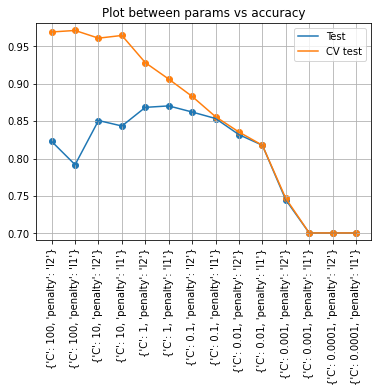

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')
plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=0.1)
clf.fit(X_train_stem, Y_train_stem)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("Yes")
model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_stem, clf.predict(X_test_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_stem, clf.predict(X_train_stem)))

print("Train accuracy : ", accuracy_score(Y_train_stem, clf.predict(X_train_stem)))
print("Test accuracy : ", accuracy_score(Y_test_stem, clf.predict(X_test_stem)))

Train accuracy :  0.8592357465510927
Test accuracy :  0.8500881834215167


## Logistic regression with BOW and not stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem, Y_train_not_stem)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   36.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

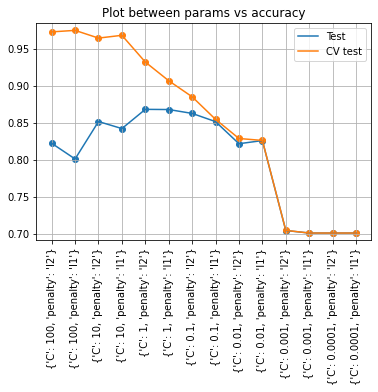

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=0.1)
clf.fit(X_train_not_stem, Y_train_not_stem)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("No")
model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))

Train accuracy :  0.858136979611769
Test accuracy :  0.84891240446796


## Light GBM with BOW and stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,24
                     00]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem, Y_train_stem)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 20.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

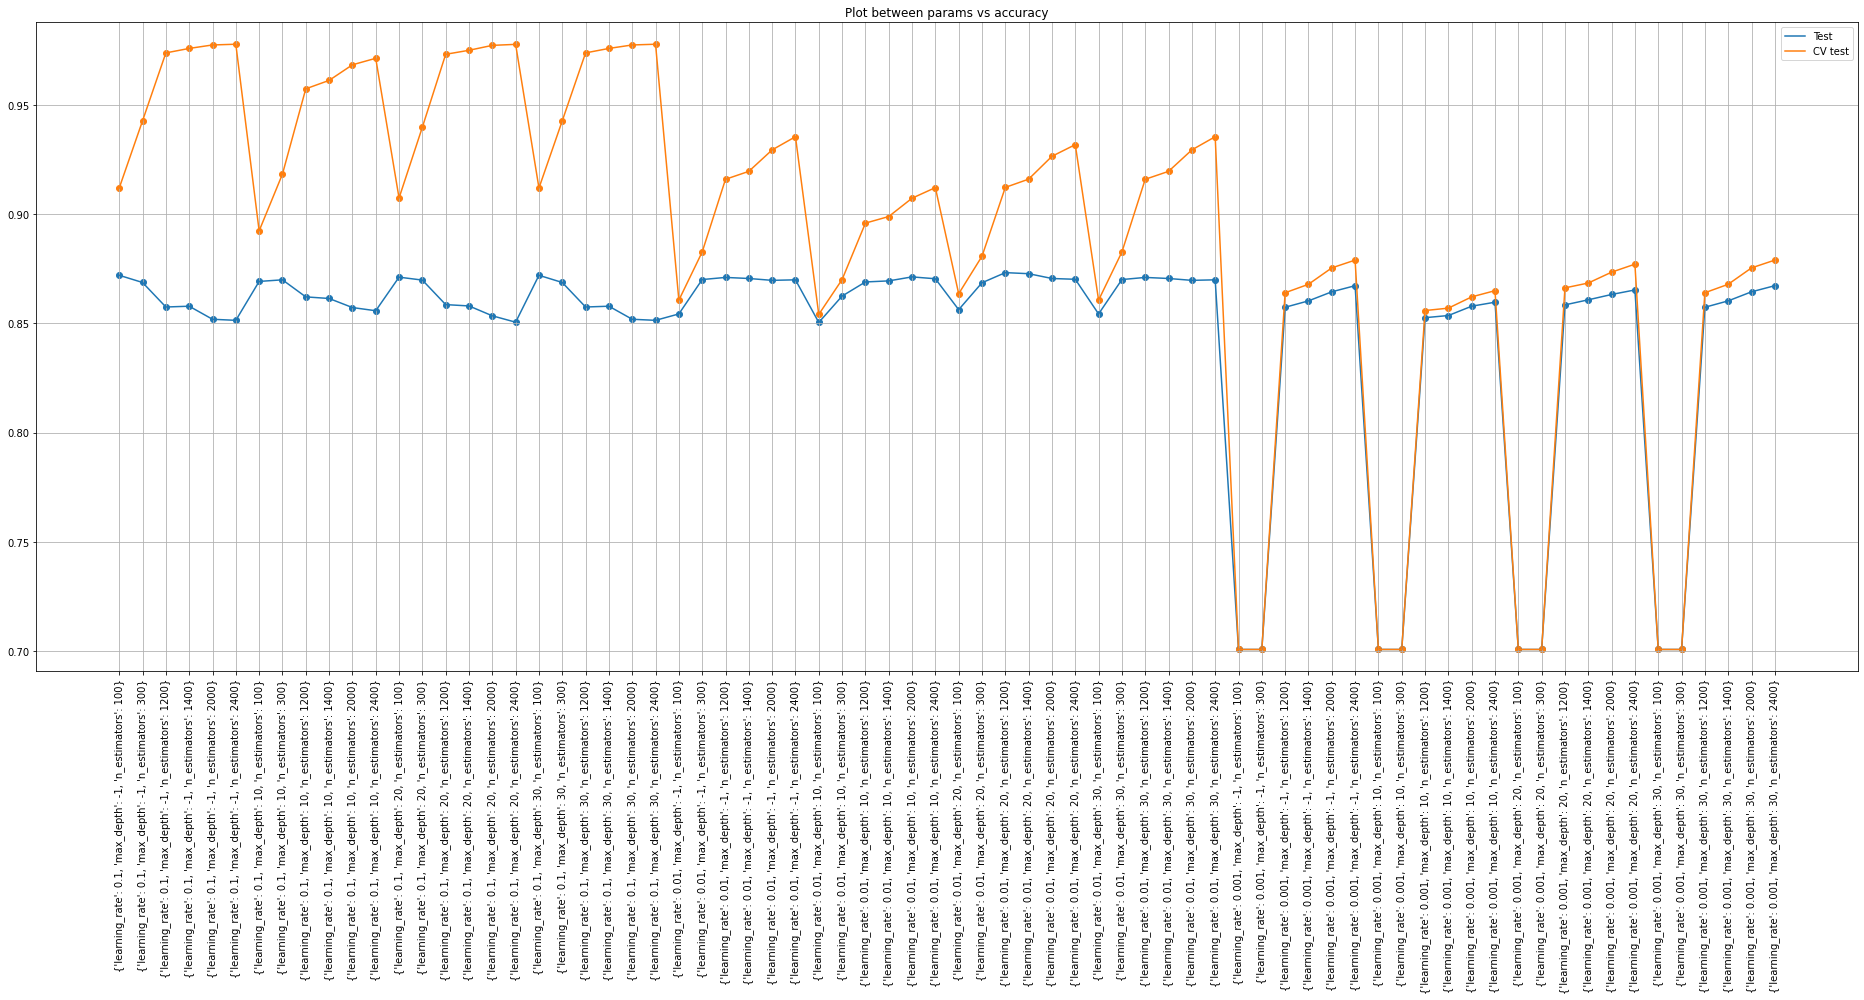

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=100, max_depth=10, learning_rate=0.01)
clf.fit(X_train_stem, Y_train_stem)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("Yes")

model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_stem, clf.predict(X_test_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_stem, clf.predict(X_train_stem)))

print("Train accuracy : ", accuracy_score(Y_train_stem, clf.predict(X_train_stem)))
print("Test accuracy : ", accuracy_score(Y_test_stem, clf.predict(X_test_stem)))

Train accuracy :  0.8541081675009157
Test accuracy :  0.8442092886537331


## Light GBM with BOW and without stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem, Y_train_not_stem)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 22.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

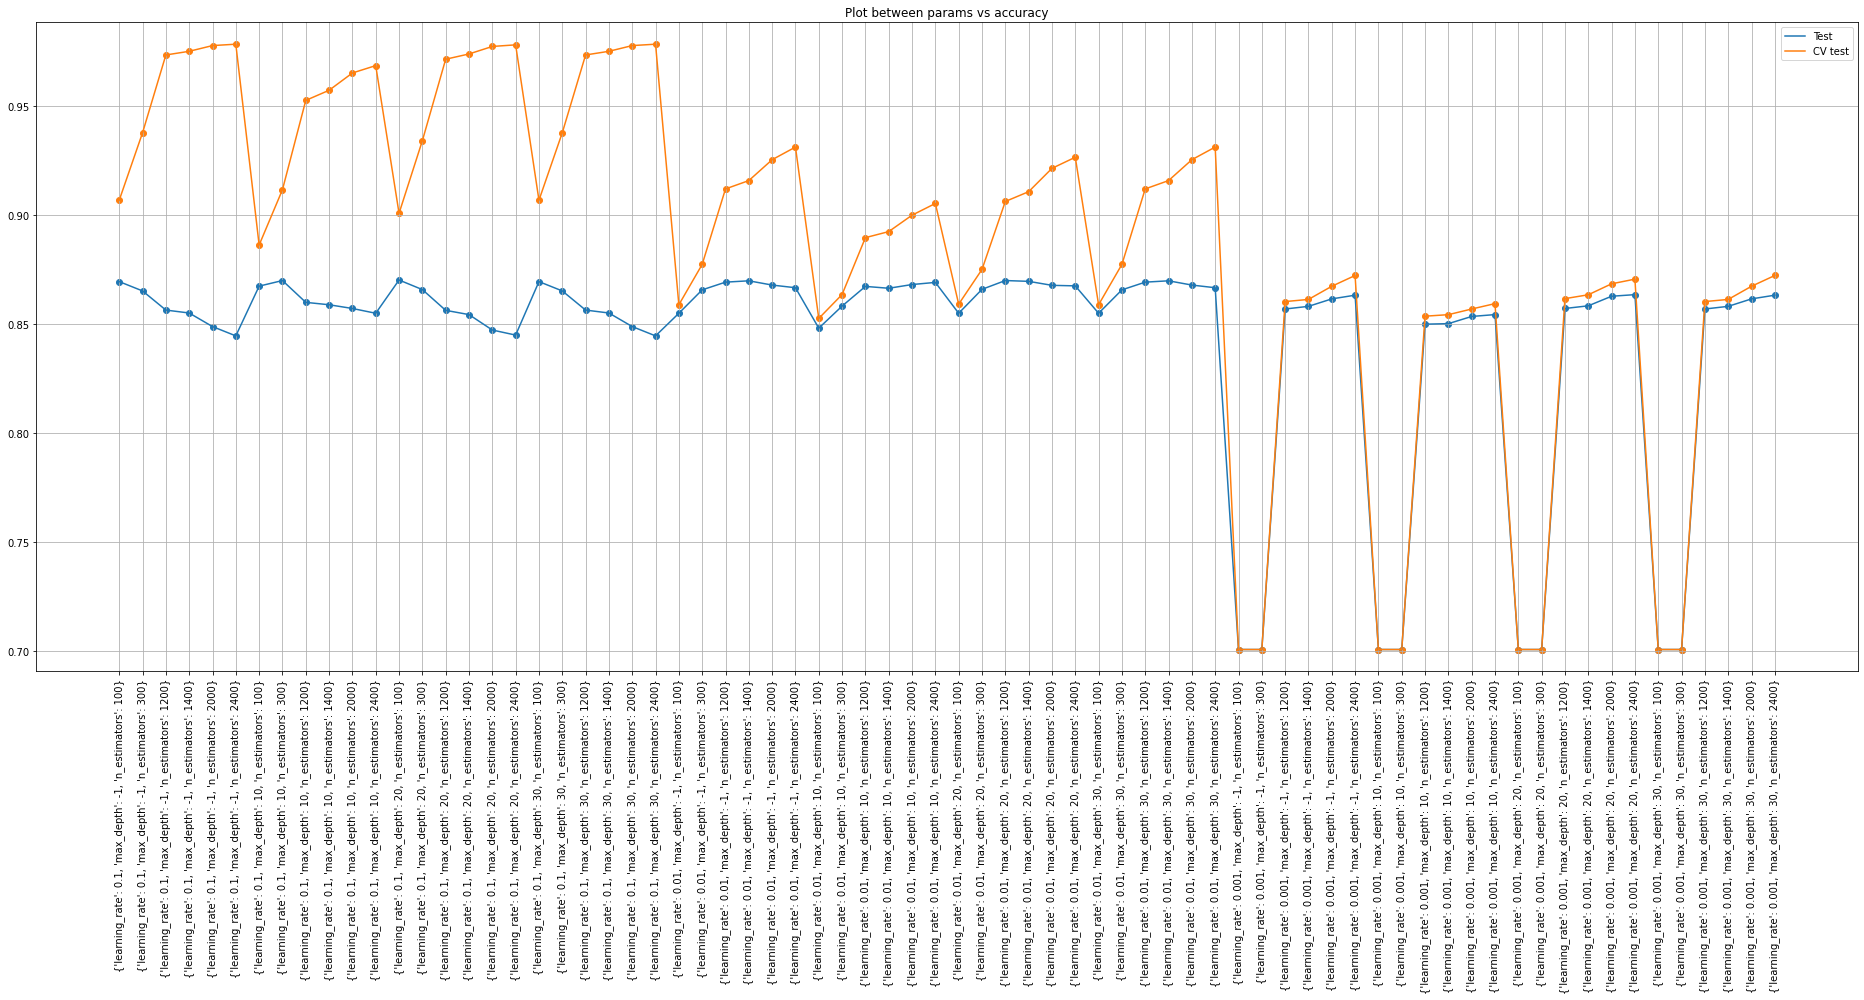

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=100, max_depth=-1, learning_rate=0.01)
clf.fit(X_train_not_stem, Y_train_not_stem)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("No")

model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))

Train accuracy :  0.8605786839213772
Test accuracy :  0.8606701940035273


## Logistic regression with TFIDF and stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem_, Y_train_stem_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   18.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

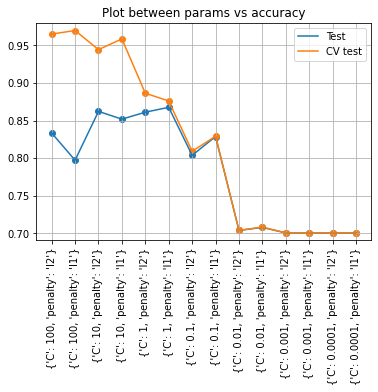

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')
plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=1)
clf.fit(X_train_stem_, Y_train_stem_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("Yes")
model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_stem_, clf.predict(X_test_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_stem_, clf.predict(X_train_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_stem, clf.predict(X_train_stem)))
print("Test accuracy : ", accuracy_score(Y_test_stem, clf.predict(X_test_stem)))

Train accuracy :  0.8570382126724454
Test accuracy :  0.8336272780717225


## Logistic regression with TFIDF and not stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem_, Y_train_not_stem_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   22.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

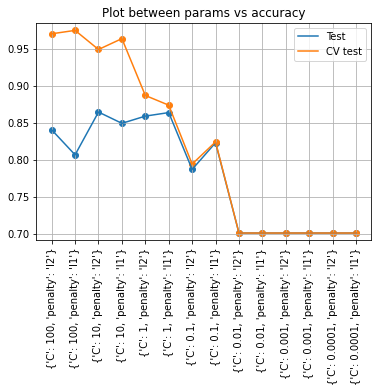

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=1)
clf.fit(X_train_not_stem_, Y_train_not_stem_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("No")
model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))

Train accuracy :  0.8747405689171042
Test accuracy :  0.8624338624338624


## Light GBM with TFIDF and stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01,
                      0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem_, Y_train_stem_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 38.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

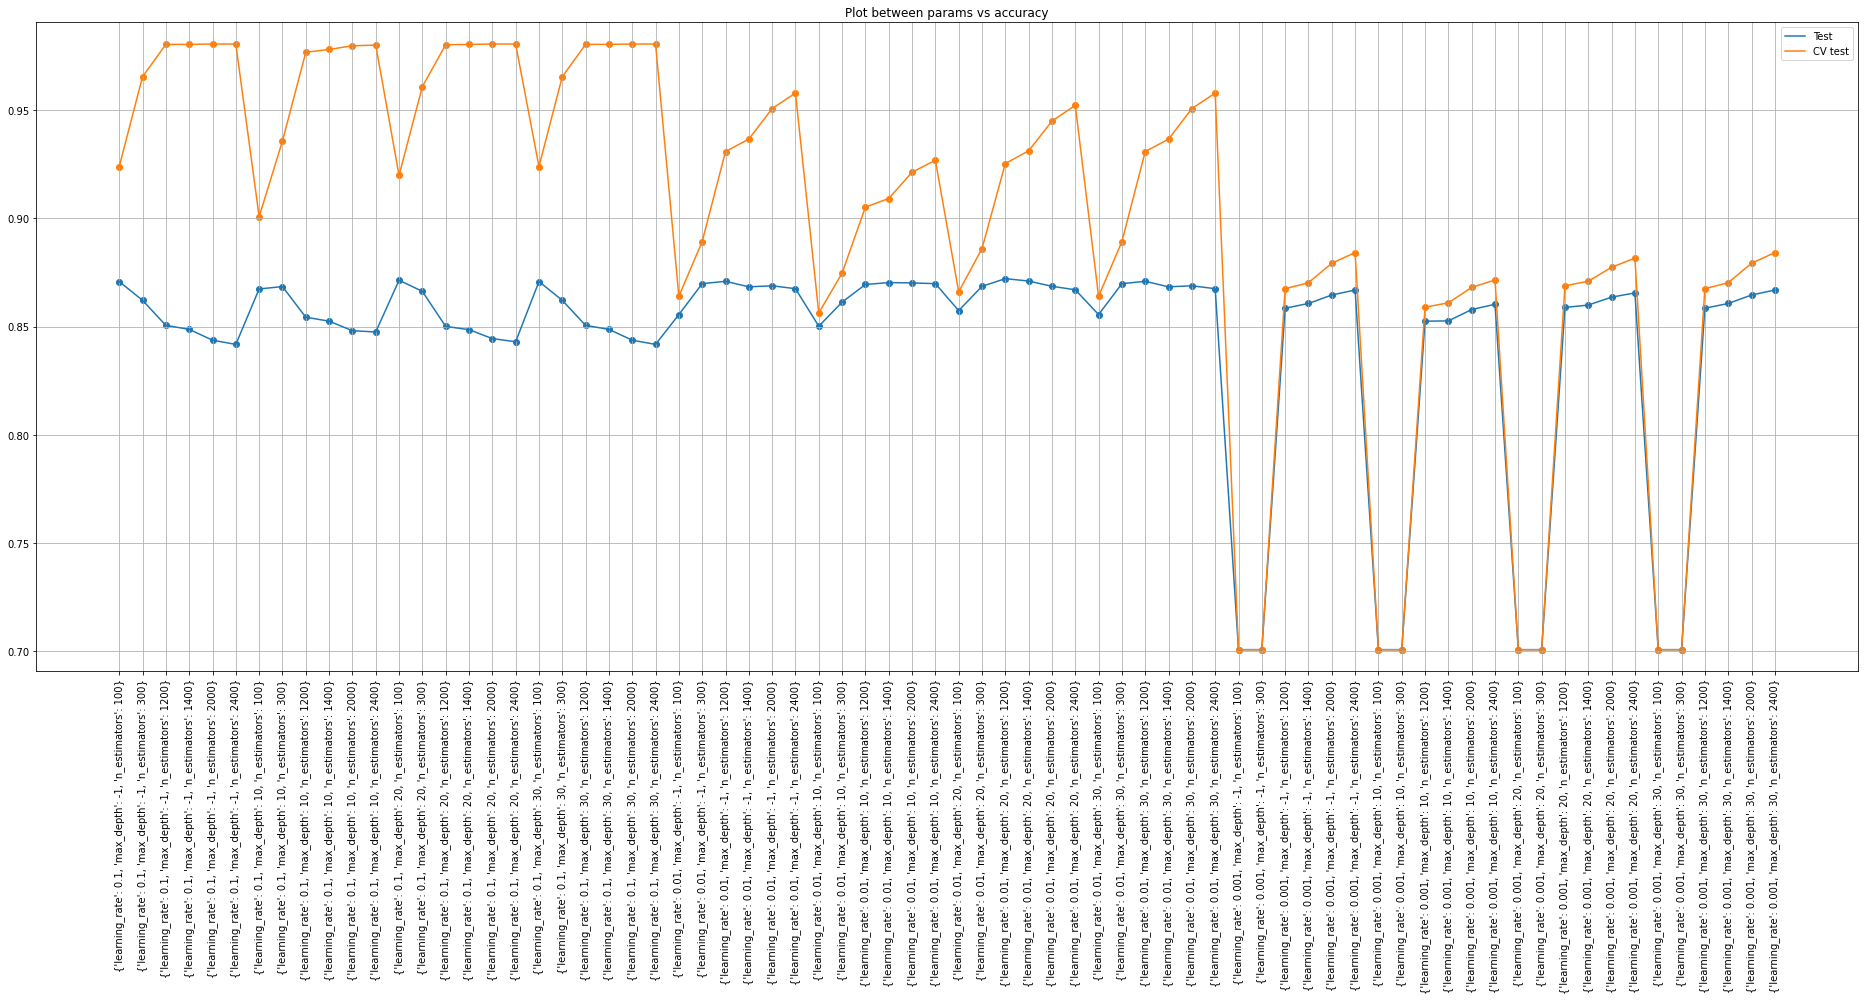

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=100, max_depth=-1, learning_rate=0.01)
clf.fit(X_train_stem_, Y_train_stem_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("Yes")

model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_stem_, clf.predict(X_test_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_stem_, clf.predict(X_train_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_stem_, clf.predict(X_train_stem_)))
print("Test accuracy : ", accuracy_score(Y_test_stem_, clf.predict(X_test_stem_)))

Train accuracy :  0.8655841777560738
Test accuracy :  0.8583186360964139


## Light GBM with TFIDF and without stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem_, Y_train_not_stem_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 40.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

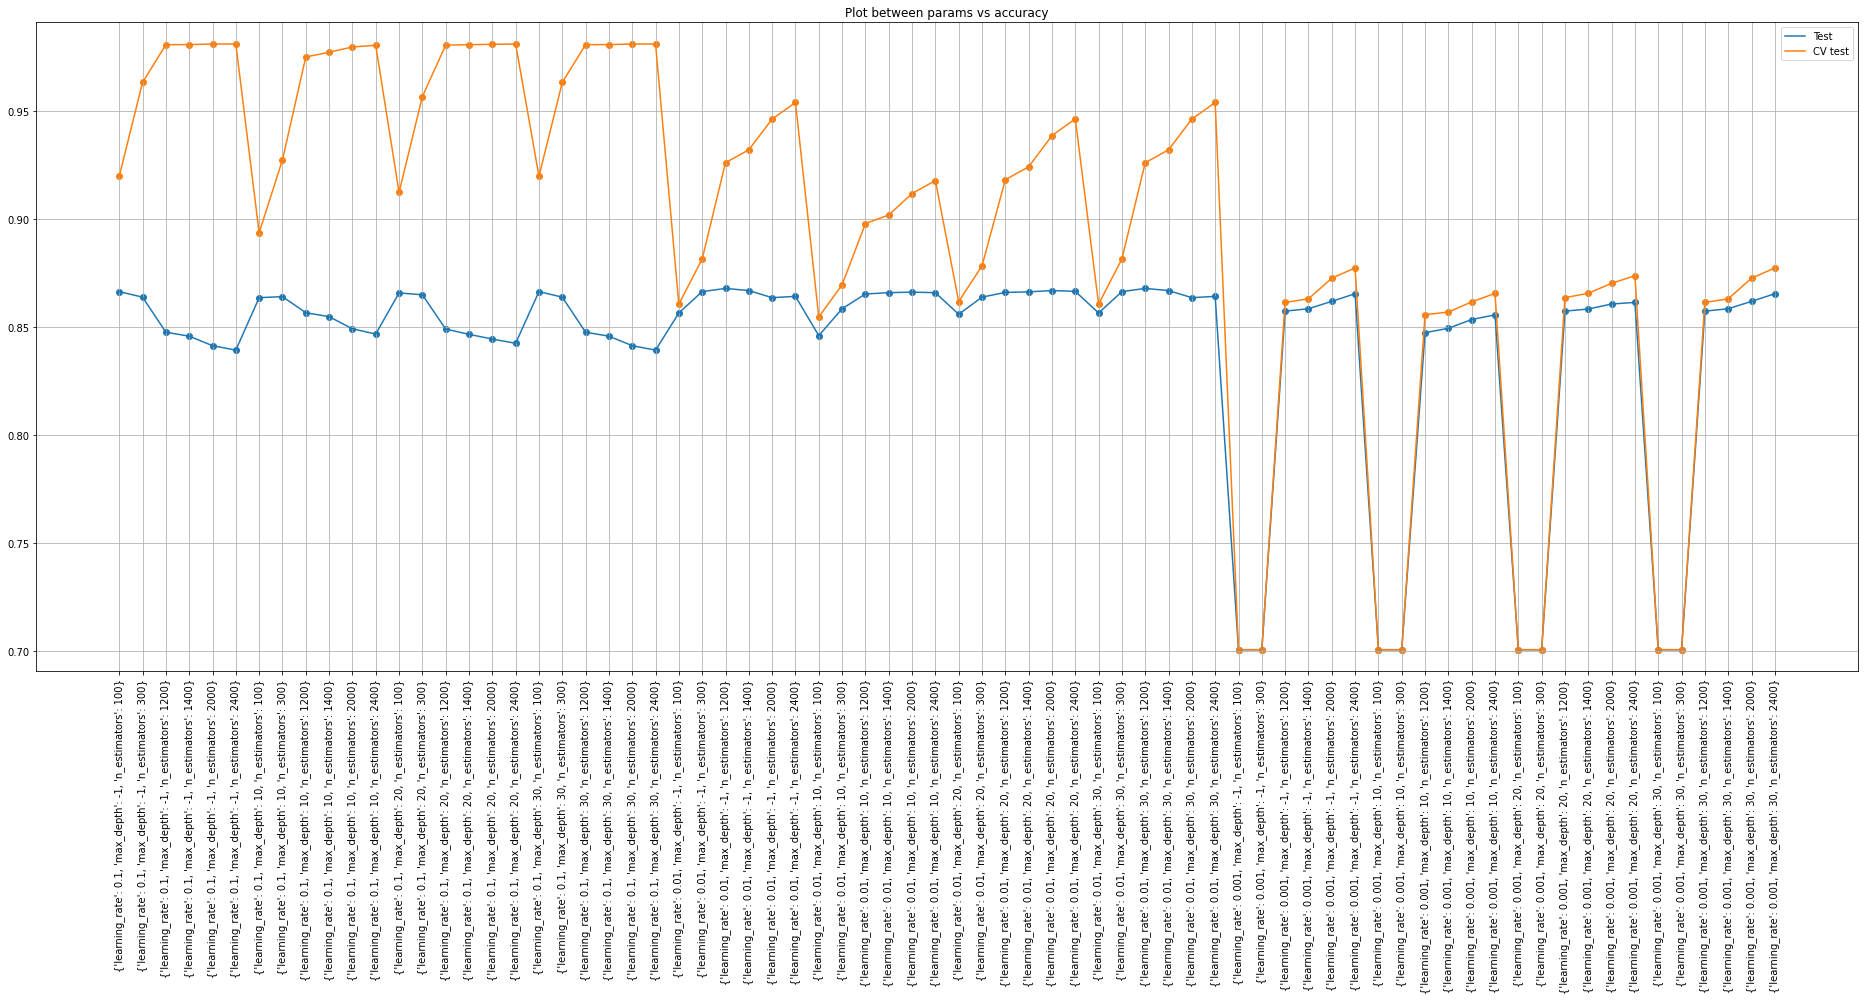

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=100, max_depth=-1, learning_rate=0.01)
clf.fit(X_train_not_stem_, Y_train_not_stem_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("No")

model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))

Train accuracy :  0.8636308143083873
Test accuracy :  0.8600823045267489


## Modeling Analysis

In [ ]:
model_df = pd.DataFrame(model)
model_df

,model,stemming,vectorizer,train_accuracy,test_accuracy
0,Logistic Rgression,Yes,BOW,0.859236,0.850088
1,Logistic Rgression,No,BOW,0.858137,0.848912
2,Light GBM,Yes,BOW,0.854108,0.844209
3,Light GBM,No,BOW,0.860579,0.860670
4,Logistic Rgression,Yes,TFIDF,0.875107,0.863022
5,Logistic Rgression,No,TFIDF,0.874741,0.862434
6,Light GBM,Yes,TFIDF,0.865584,0.858319
7,Light GBM,No,TFIDF,0.863631,0.860082


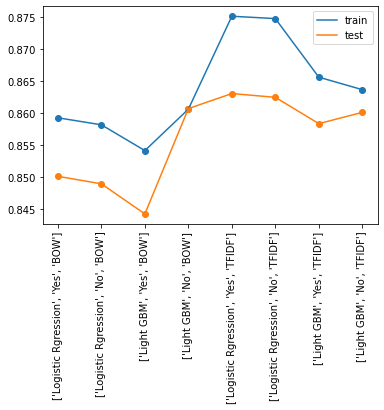

In [ ]:
plt.plot(model_df['train_accuracy'], label="train")
plt.plot(model_df['test_accuracy'], label="test")

plt.scatter(np.arange(0, model_df.shape[0]),model_df['train_accuracy'])
plt.scatter(np.arange(0, model_df.shape[0]),model_df['test_accuracy'])

plt.xticks(np.arange(0, model_df.shape[0]), [[i, j, k] for i, j, k in zip(model_df['model'], model_df['stemming'], model_df['vectorizer'])], rotation='vertical')

plt.legend()
plt.show()

<h1>Observation</h1>
We are using same modelling techniques lightgbm and logistic regression and with same options as earlier.

<h1>Conclusion</h1>

The highest test accuracy achieved is in range of 86 and most of them have no stemming with TFIDF as vectorizer. 

In this experiment we are able to beat 6 modelling techniques but only Logistic regression with scores of 86.24 and 86.30.

Lets keep TFIDF as vectorizer without stemming and with Logistic regression. 

# Modelling ogling

In [ ]:
model = {
    "model": [],
    "stemming": [],
    "vectorizer": [],
    "train_accuracy": [],
    "test_accuracy": []
}

In [ ]:
# stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=True, rm_stopword=True, 
                             vectorizer="bow", min_df=1, max_df=1404, category="ogling")

Y_train_stem, X_train_stem = train['Category'], train.drop(['Category'], axis=1)
Y_test_stem, X_test_stem = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walk,along,crowd,street,hold,mum,hand,elder,man,grope,butt,turn,look,h7m,away,while,12,yrs,old,then,incid,took,place,evening,metro,two,guy,start,staring,wait,bus,came,bike,offer,liftvto,young,girls,happen,insid,train,...,uma,begumpet,kundanbagh,kilomet,cries,ba,9861,ameerpet,youngsters,leelanagar,imax,perverts,lout,muscular,boda,oper,ferri,thye,curvi,sweets,underag,relis,gr,senset,onlook,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutub,downloaderlt,agt,folow,offending,cgrope,timr,Category
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# not stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=False, rm_stopword=True, 
                             vectorizer="bow", min_df=1, max_df=1404, category="ogling")

Y_train_not_stem, X_train_not_stem = train['Category'], train.drop(['Category'], axis=1)
Y_test_not_stem, X_test_not_stem = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walking,along,crowded,street,holding,mums,hand,elderly,man,groped,butt,turned,look,h7m,looked,away,while,12,yrs,old,then,incident,took,place,evening,metro,two,guys,started,staring,waiting,bus,came,bike,offering,liftvto,young,girls,happened,inside,...,ameerpet,leelanagar,echoes,imax,crack,powerful,muscular,photocopying,boda,operators,ferry,thye,shapes,curvy,identifying,policing,oftenly,underage,relise,mention,gr,sensetive,impregnates,onlookers,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutube,downloaderlt,agt,folowing,cgroping,timr,conducter,gift,Category
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=True, rm_stopword=True, 
                             vectorizer="tfidf", min_df=1, max_df=1404, category="ogling")

Y_train_stem_, X_train_stem_ = train['Category'], train.drop(['Category'], axis=1)
Y_test_stem_, X_test_stem_ = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walk,along,crowd,street,hold,mum,hand,elder,man,grope,butt,turn,look,h7m,away,while,12,yrs,old,then,incid,took,place,evening,metro,two,guy,start,staring,wait,bus,came,bike,offer,liftvto,young,girls,happen,insid,train,...,uma,begumpet,kundanbagh,kilomet,cries,ba,9861,ameerpet,youngsters,leelanagar,imax,perverts,lout,muscular,boda,oper,ferri,thye,curvi,sweets,underag,relis,gr,senset,onlook,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutub,downloaderlt,agt,folow,offending,cgrope,timr,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# stemming
train, test, _ =  fetch_data(root_dir=root_dir, label_type='binary', stem=False, rm_stopword=True, 
                             vectorizer="tfidf", min_df=1, max_df=1404, category="ogling")

Y_train_not_stem_, X_train_not_stem_ = train['Category'], train.drop(['Category'], axis=1)
Y_test_not_stem_, X_test_not_stem_ = test['Category'], test.drop(['Category'], axis=1) 

train.head()

,walking,along,crowded,street,holding,mums,hand,elderly,man,groped,butt,turned,look,h7m,looked,away,while,12,yrs,old,then,incident,took,place,evening,metro,two,guys,started,staring,waiting,bus,came,bike,offering,liftvto,young,girls,happened,inside,...,ameerpet,leelanagar,echoes,imax,crack,powerful,muscular,photocopying,boda,operators,ferry,thye,shapes,curvy,identifying,policing,oftenly,underage,relise,mention,gr,sensetive,impregnates,onlookers,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutube,downloaderlt,agt,folowing,cgroping,timr,conducter,gift,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Logistic regression with BOW and stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem, Y_train_stem)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   34.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

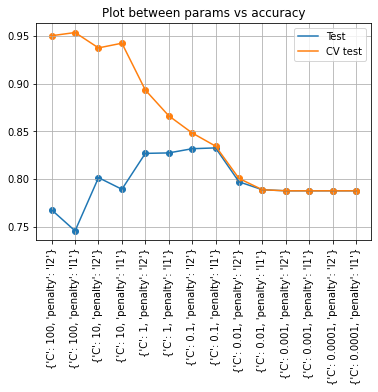

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')
plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=0.1)
clf.fit(X_train_stem, Y_train_stem)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("Yes")
model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_stem, clf.predict(X_test_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_stem, clf.predict(X_train_stem)))

print("Train accuracy : ", accuracy_score(Y_train_stem, clf.predict(X_train_stem)))
print("Test accuracy : ", accuracy_score(Y_test_stem, clf.predict(X_test_stem)))

Train accuracy :  0.8354291295324137
Test accuracy :  0.8271604938271605


## Logistic regression with BOW and not stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem, Y_train_not_stem)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   38.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

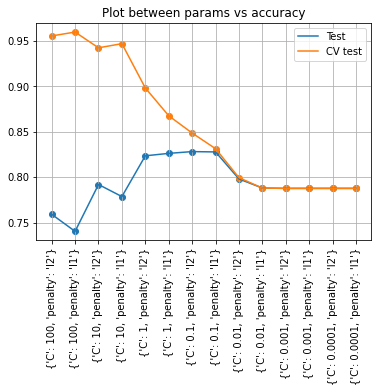

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=0.1)
clf.fit(X_train_not_stem, Y_train_not_stem)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("No")
model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))

Train accuracy :  0.8332315956537664
Test accuracy :  0.8212815990593768


## Light GBM with BOW and stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem, Y_train_stem)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 20.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

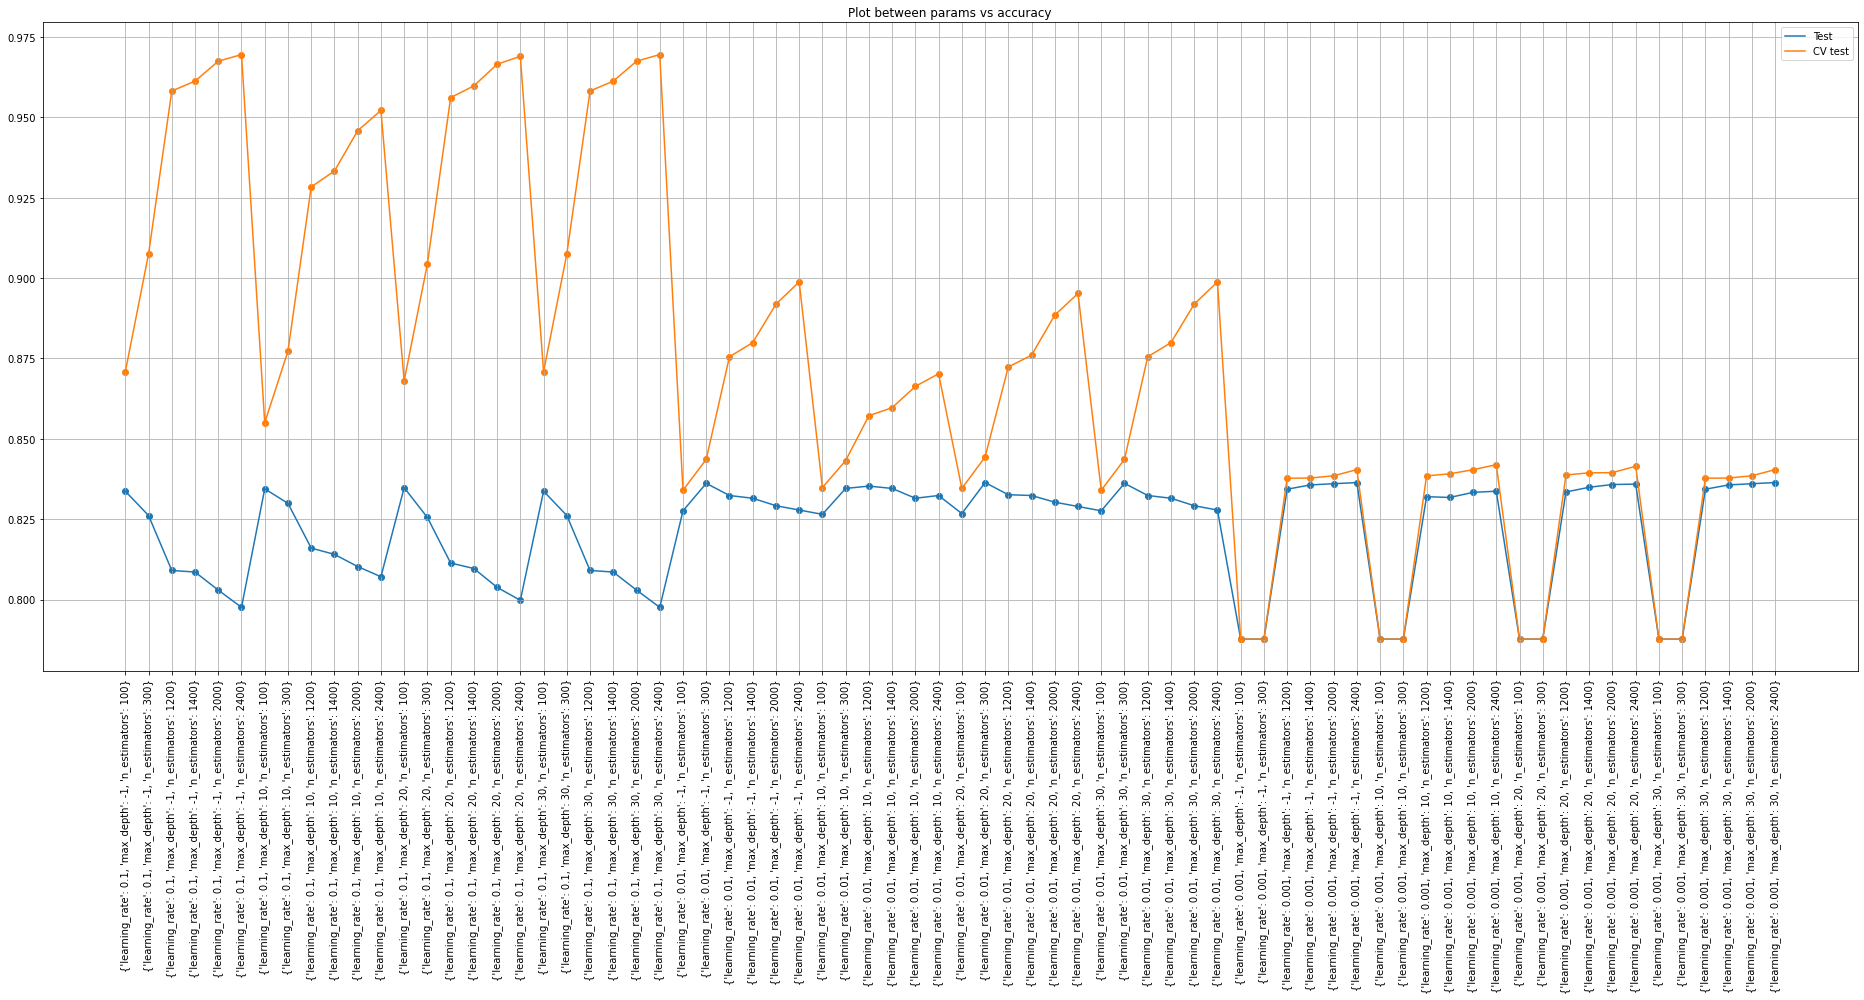

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=300, max_depth=-1, learning_rate=0.01)
clf.fit(X_train_stem, Y_train_stem)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("Yes")

model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_stem, clf.predict(X_test_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_stem, clf.predict(X_train_stem)))

print("Train accuracy : ", accuracy_score(Y_train_stem, clf.predict(X_train_stem)))
print("Test accuracy : ", accuracy_score(Y_test_stem, clf.predict(X_test_stem)))

Train accuracy :  0.843975094616042
Test accuracy :  0.8289241622574955


## Light GBM with BOW and without stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem, Y_train_not_stem)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 21.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

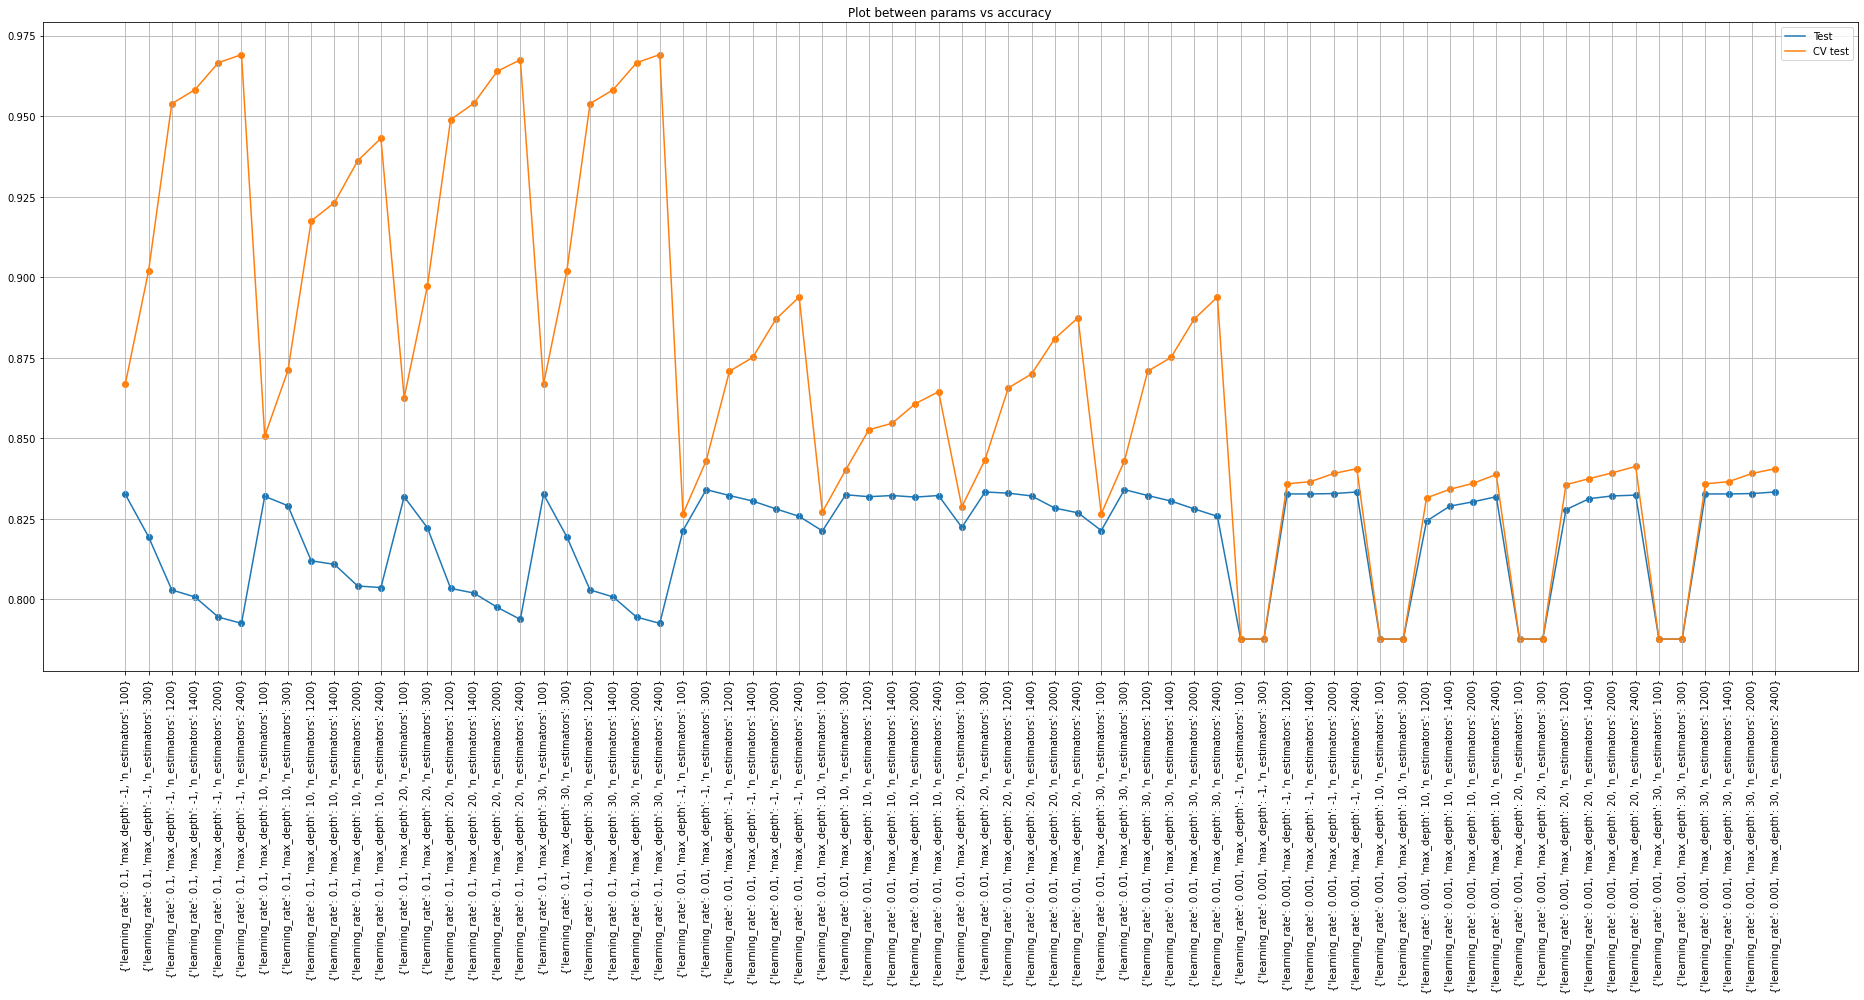

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=1200, max_depth=-1, learning_rate=0.001)
clf.fit(X_train_not_stem, Y_train_not_stem)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("No")

model['vectorizer'].append("BOW")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem, clf.predict(X_train_not_stem)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem, clf.predict(X_test_not_stem)))

Train accuracy :  0.8357953851788549
Test accuracy :  0.8277483833039389


## Logistic regression with TFIDF and stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem_, Y_train_stem_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

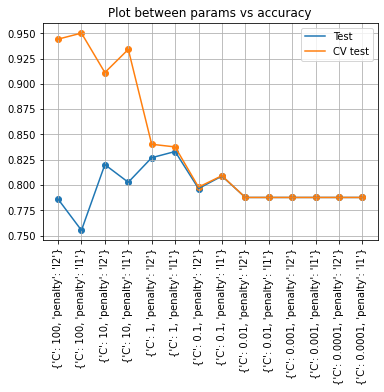

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')
plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=1)
clf.fit(X_train_stem_, Y_train_stem_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("Yes")
model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_stem_, clf.predict(X_test_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_stem_, clf.predict(X_train_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_stem, clf.predict(X_train_stem)))
print("Test accuracy : ", accuracy_score(Y_test_stem, clf.predict(X_test_stem)))

Train accuracy :  0.8052740813087536
Test accuracy :  0.770135214579659


## Logistic regression with TFIDF and not stemming

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)

params ={
    "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ['l2', 'l1']
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem_, Y_train_not_stem_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   18.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

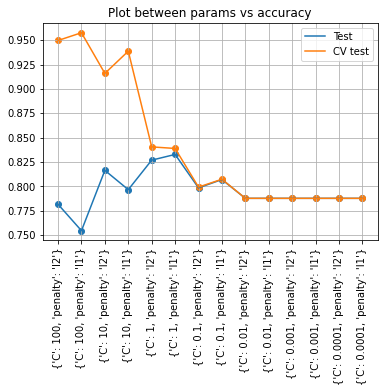

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, penalty='l1', C=1)
clf.fit(X_train_not_stem_, Y_train_not_stem_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model['model'].append("Logistic Rgression")
model['stemming'].append("No")
model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))

Train accuracy :  0.8398241972897083
Test accuracy :  0.8265726043503822


## Light GBM with TFIDF and stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01,
                      0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_stem_, Y_train_stem_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 40.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

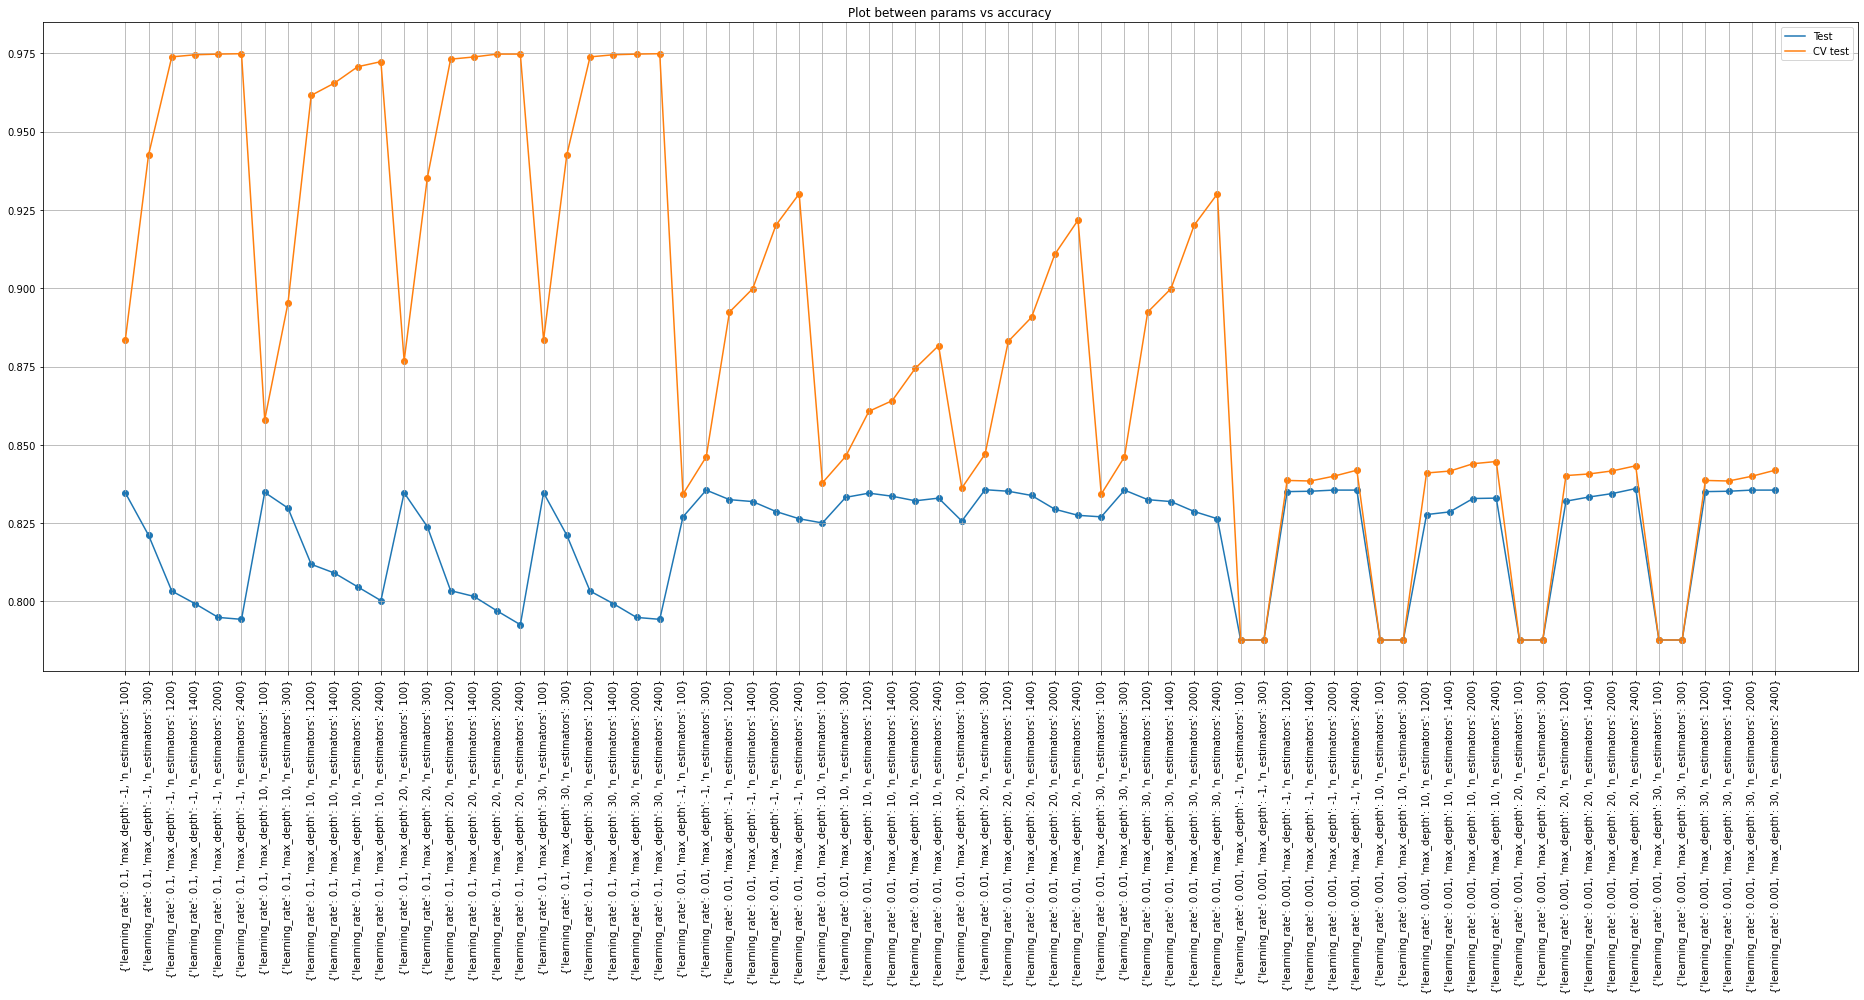

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=1200, max_depth=-1, learning_rate=0.001)
clf.fit(X_train_stem_, Y_train_stem_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("Yes")

model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_stem_, clf.predict(X_test_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_stem_, clf.predict(X_train_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_stem_, clf.predict(X_train_stem_)))
print("Test accuracy : ", accuracy_score(Y_test_stem_, clf.predict(X_test_stem_)))

Train accuracy :  0.838847515565865
Test accuracy :  0.8283362727807172


## Light GBM with TFIDF and without stemming

In [ ]:
clf = LGBMClassifier(random_state=42)


params ={
    "max_depth": [-
                  1, 10, 20, 30], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [100, 300, 1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train_not_stem_, Y_train_not_stem_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 40.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth'

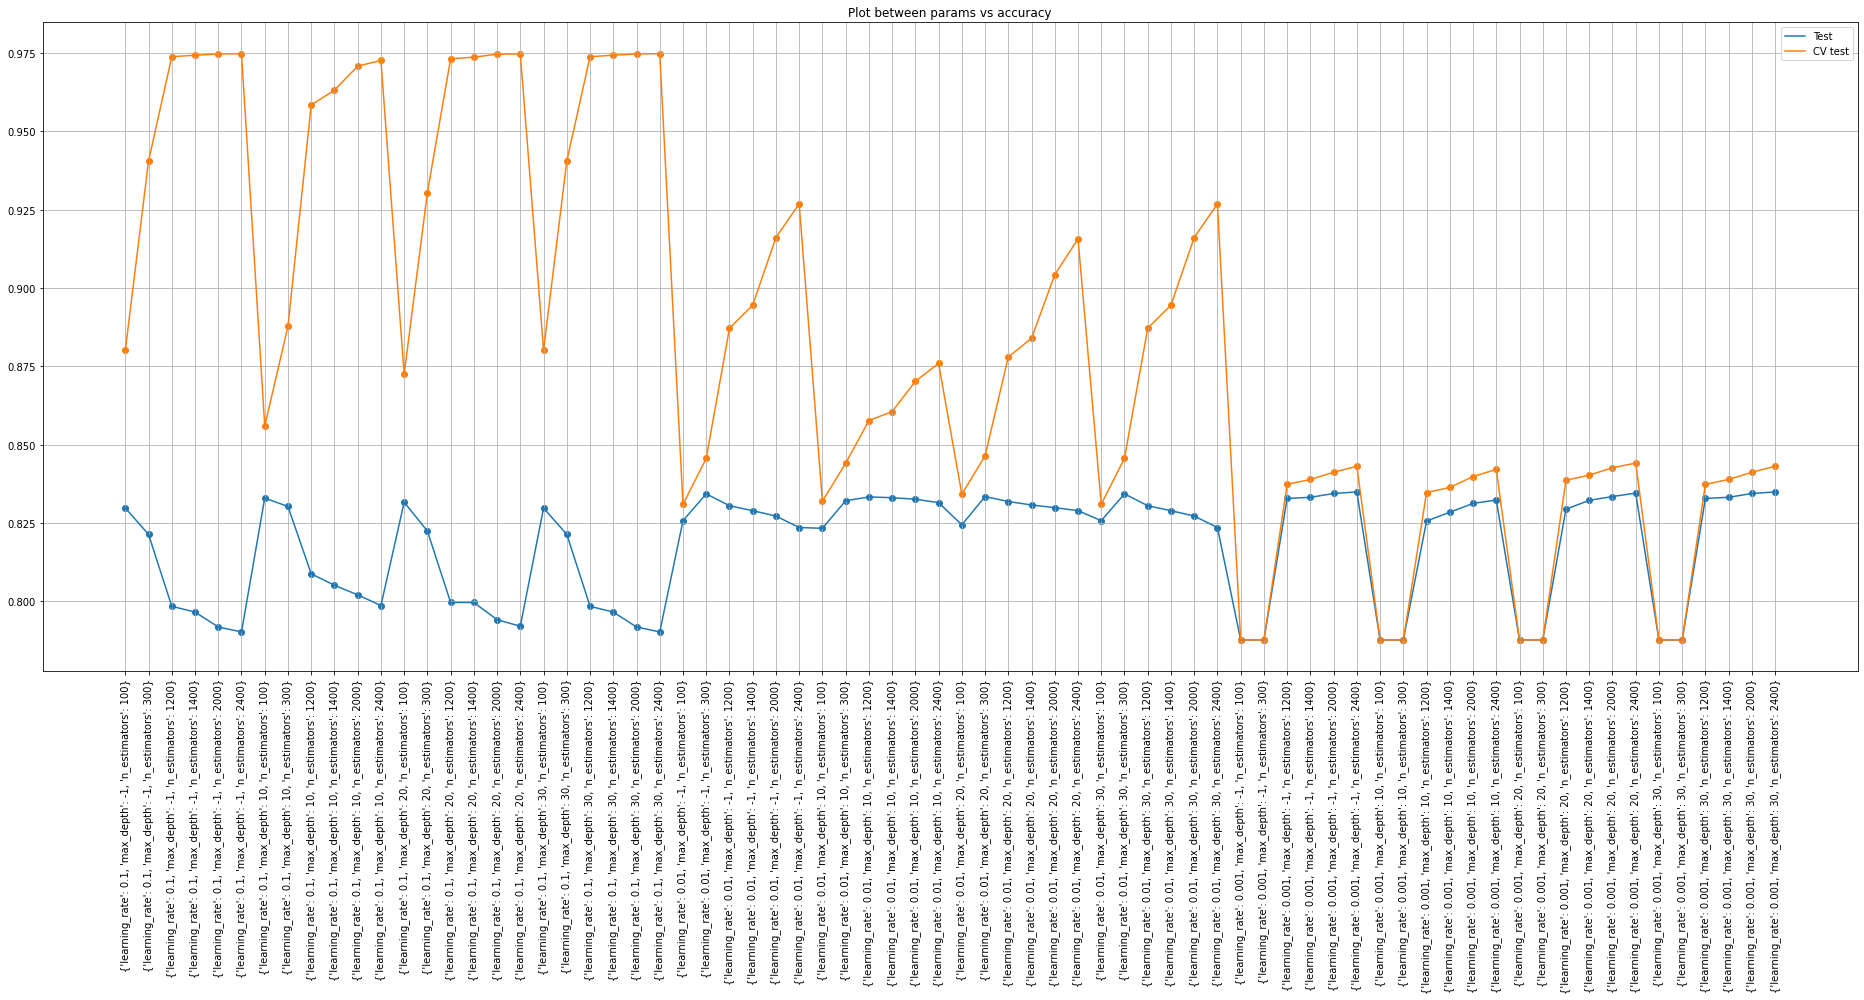

In [ ]:
plt.figure(figsize=(26,14))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, n_estimators=1200, max_depth=-1, learning_rate=0.001)
clf.fit(X_train_not_stem_, Y_train_not_stem_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model['model'].append("Light GBM")
model['stemming'].append("No")

model['vectorizer'].append("TFIDF")
model['test_accuracy'].append(accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))
model['train_accuracy'].append(accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))

print("Train accuracy : ", accuracy_score(Y_train_not_stem_, clf.predict(X_train_not_stem_)))
print("Test accuracy : ", accuracy_score(Y_test_not_stem_, clf.predict(X_test_not_stem_)))

Train accuracy :  0.837626663411061
Test accuracy :  0.8289241622574955


## Modeling Analysis

In [ ]:
model_df = pd.DataFrame(model)
model_df

,model,stemming,vectorizer,train_accuracy,test_accuracy
0,Logistic Rgression,Yes,BOW,0.835429,0.827160
1,Logistic Rgression,No,BOW,0.833232,0.821282
2,Light GBM,Yes,BOW,0.843975,0.828924
3,Light GBM,No,BOW,0.835795,0.827748
4,Logistic Rgression,Yes,TFIDF,0.838725,0.818930
5,Logistic Rgression,No,TFIDF,0.839824,0.826573
6,Light GBM,Yes,TFIDF,0.838848,0.828336
7,Light GBM,No,TFIDF,0.837627,0.828924


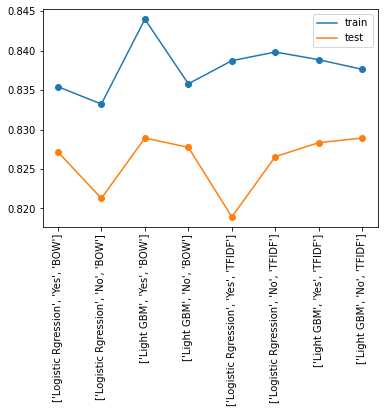

In [ ]:
plt.plot(model_df['train_accuracy'], label="train")
plt.plot(model_df['test_accuracy'], label="test")

plt.scatter(np.arange(0, model_df.shape[0]),model_df['train_accuracy'])
plt.scatter(np.arange(0, model_df.shape[0]),model_df['test_accuracy'])

plt.xticks(np.arange(0, model_df.shape[0]), [[i, j, k] for i, j, k in zip(model_df['model'], model_df['stemming'], model_df['vectorizer'])], rotation='vertical')

plt.legend()
plt.show()

<h1>Observation</h1>
We are using same modelling techniques lightgbm and logistic regression and with same options as earlier.

<h1>Conclusion</h1>

The highest test accuracy achieved is in range of 82 and the highest amongst them is 82.89 having no stemming with TFIDF as vectorizer. 

In this experiment we are able to beat 6 modelling techniques with both Logistic regression and LightGBM.

Lets keep TFIDF as vectorizer without stemming and with Logistic regression beacuse we have choosen LR for commenting as well as for groping.